In [65]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

sector_etfs = ['XLE', 'XLF', 'XLK', 'XLI', 'XLB', 'XLV', 'XLY', 'XLP', 'XLU', 'XLRE'] # Add XLC?
sector_twin_etfs = [
    'XLF', 'VFH',   # Financials
    'XLK', 'VGT',   # Tech
    'XLY', 'VCR',   # Consumer Discretionary
    'XLP', 'VDC',   # Consumer Staples
    'XLV', 'VHT',   # Healthcare
    'XLE', 'VDE',   # Energy
    'XLI', 'VIS',   # Industrials
    'XLB', 'VAW',   # Materials
    'XLU', 'VPU',   # Utilities
    'XLRE', 'VNQ',  # Real Estate
    'VOX',   # Comms without XLC
]
dividend_etfs = ['VYM', 'HDV', 'SCHD', 'DVY']
bond_etfs = ['SHY', 'VGSH', 'IEF', 'TLH', 'TLT', 'SPTL']
industry_etfs = ['KBE', 'XOP', 'IHF', 'SOXX', 'ITA', 'IBB']
international_etfs = ['EFA', 'VEA', 'IEMG', 'EEM', 'EWJ', 'EWU', 'EWG', 'FXI', 'EWZ']
broad_index_etfs = ['SPY', 'VOO', 'IVV', 'DIA', 'IWM', 'QQQ', 'RSP', 'QQEW']
thematic_etfs = ['ARKK', 'ARKW', 'ROBO', 'BOTZ', 'TAN', 'ICLN', 'LIT'] # Add BATT?

etf_categories = {
    'sector': sector_etfs,
    'sector_twins': sector_twin_etfs,
    'dividend': dividend_etfs,
    'bond': bond_etfs,
    'international': international_etfs,
    'broad_index': broad_index_etfs,
    'thematic': thematic_etfs,
}

flattened_etfs = [etf for etfs in etf_categories.values() for etf in etfs]

prices = yf.download(flattened_etfs, start = '2010-01-01', end = '2019-12-31')['Close']

for etf in prices.columns:
    data = prices[etf]

    if data.empty:
        print(f"{etf} does not contain data")

# Pearson correlation

for category, etfs in etf_categories.items():
    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    returns = category_prices.pct_change().dropna()

    correlation_matrix = returns.corr()
    correlation_matrix = correlation_matrix.rename_axis(None).rename_axis(None, axis = 1)
    correlation_matrix = correlation_matrix.stack().reset_index()
    correlation_matrix.columns = ['ETF', 'Pair', 'Correlation']

    correlation_matrix =  correlation_matrix[correlation_matrix['ETF'] != correlation_matrix['Pair']]
    correlation_matrix = correlation_matrix.sort_values(by = 'Correlation', ascending = False)
    correlation_matrix = correlation_matrix.drop_duplicates('Correlation')

    potential_pairs = correlation_matrix[correlation_matrix['Correlation'] > 0.8]

    print(f"Potential Correlated Pairs from {category}:")
    print(potential_pairs)

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_45596/3770512257.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(flattened_etfs, start = '2010-01-01', end = '2019-12-31')['Close']
[*********************100%***********************]  55 of 55 completed


Potential Correlated Pairs from sector:
    ETF Pair  Correlation
26  XLK  XLY     0.847600
43  XLB  XLI     0.834226
13  XLF  XLI     0.803238
Potential Correlated Pairs from sector_twins:
      ETF Pair  Correlation
221   XLE  VDE     0.995401
373   VPU  XLU     0.993256
153   VDC  XLP     0.992817
21    VFH  XLF     0.992749
45    XLK  VGT     0.992254
89    XLY  VCR     0.991976
285   VIS  XLI     0.991683
177   XLV  VHT     0.988900
329   VAW  XLB     0.984735
397  XLRE  VNQ     0.931969
288   VIS  VAW     0.867210
108   VCR  VGT     0.853578
107   VCR  XLK     0.849242
267   XLI  VAW     0.848993
67    VGT  XLY     0.848930
86    XLY  XLK     0.847600
307   XLB  VIS     0.843717
266   XLI  XLB     0.834226
278   VIS  VCR     0.825232
34    VFH  VIS     0.823905
273   VIS  XLF     0.818597
97    XLY  VIS     0.809018
33    VFH  XLI     0.803381
252   XLI  XLF     0.803238
117   VCR  XLI     0.802500
Potential Correlated Pairs from dividend:
     ETF  Pair  Correlation
2    VYM  SC

In [60]:
# checking data point count
etf_data_counts = prices.notna().sum().sort_values()

etf_data_coverage = etf_data_counts.to_frame(name='Available Days')
etf_data_coverage.index.name = 'ETF'

print(etf_data_coverage.head(10)) 

      Available Days
ETF                 
BOTZ             830
XLRE            1064
ARKK            1299
ARKW            1322
ROBO            1558
IEMG            1806
SCHD            2061
HDV             2202
VOO             2343
LIT             2376


In [61]:
# cointegration

for category, etfs in etf_categories.items():

        candidate_pairs = []

        desired_etfs = [etf for etf in etfs]

        category_prices = prices[desired_etfs]

        for i in range(len(desired_etfs)):
                for j in range(i + 1, len(desired_etfs)):
                        candidate_pairs.append([desired_etfs[i], desired_etfs[j]])

        cointegrated_pairs = []

        for etf1, etf2 in candidate_pairs:

                df = category_prices[[etf1, etf2]].dropna()

                s_etf1 = df[etf1]
                s_etf2 = df[etf2]

                score, pvalue, _ = coint(s_etf1, s_etf2)

                if pvalue < 0.05:
                        cointegrated_pairs.append((etf1, etf2, pvalue))
                        
        cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs, columns = ['ETF', 'Pair', 'P-Value'])
        cointegrated_pairs_df = cointegrated_pairs_df.sort_values('P-Value').reset_index(drop=True)

        print(f"Cointegration Test Results for {category}:")
        print(cointegrated_pairs_df)

Cointegration Test Results for sector:
   ETF  Pair   P-Value
0  XLI   XLB  0.003161
1  XLU  XLRE  0.009561
2  XLY   XLU  0.014643
3  XLF   XLI  0.016249
4  XLI   XLU  0.026338
5  XLB   XLU  0.039936
Cointegration Test Results for sector_twins:
    ETF  Pair   P-Value
0   XLP   VNQ  0.000403
1   VDC   VNQ  0.000858
2   VIS   XLB  0.002114
3   XLI   XLB  0.003161
4   XLU  XLRE  0.009561
5   VFH   XLI  0.013609
6   XLY   XLU  0.014643
7   XLF   XLI  0.016249
8   VPU  XLRE  0.019591
9   XLI   VPU  0.021824
10  VCR   VPU  0.024230
11  XLU   VNQ  0.024904
12  XLI   XLU  0.026338
13  VIS   VPU  0.027383
14  XLY   VPU  0.028308
15  VIS   XLU  0.031538
16  XLB   VPU  0.036763
17  XLF   VIS  0.038168
18  XLB   XLU  0.039936
19  VFH   VIS  0.043137
20  XLV   VNQ  0.043287
21  VPU   VNQ  0.047769
Cointegration Test Results for dividend:
   ETF Pair   P-Value
0  VYM  DVY  0.003767
Cointegration Test Results for bond:
   ETF  Pair   P-Value
0  IEF   TLH  0.007770
1  TLH   TLT  0.008772
2  IEF   TLT

In [62]:
# rolling cointegration

window_size = 504
min_passes = 0.5
step = 30

for category, etfs in etf_categories.items():

    candidate_pairs = []
    rolling_cointegrated_pairs = []

    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    for i in range(len(desired_etfs)):
        for j in range(i + 1, len(desired_etfs)):
                candidate_pairs.append([desired_etfs[i], desired_etfs[j]])

    for etf1, etf2 in candidate_pairs:
            
        df = category_prices[[etf1, etf2]].dropna()

        s_etf1 = df[etf1]
        s_etf2 = df[etf2]

        df = pd.concat([s_etf1, s_etf2], axis = 1)

        if len(df[etf1]) == 0:
            print(f"{etf1} does not have sufficient data")
            continue
        elif len(df[etf2]) == 0:
            print(f"{etf2} does not have sufficient data")
            continue
            
        series1 = df.iloc[:, 0]
        series2 = df.iloc[:, 1]

        cointegrated_windows = 0
        total_windows = 0

        for start in range(0, len(df) - window_size + 1, step):
            end = start + window_size

            window_s1 = series1.iloc[start:end]
            window_s2 = series2.iloc[start:end]
                
            score, pvalue, _ = coint(window_s1, window_s2)
            total_windows += 1
                
            if pvalue < 0.05:
                cointegrated_windows += 1

        if cointegrated_windows / total_windows >= min_passes:
            rolling_cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})


    rolling_cointegrated_pairs_df = pd.DataFrame(rolling_cointegrated_pairs)

    if rolling_cointegrated_pairs_df.empty:
        print(f"{category} has no rolling cointegrated pairs.")
        continue
    else:
        rolling_cointegrated_pairs_df = rolling_cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop=True)
        print(f"Rolling Cointegration Test Results for {category}:")
        print(rolling_cointegrated_pairs_df)

Rolling Cointegration Test Results for sector:
  ETF1  ETF2    Pass %
0  XLU  XLRE  0.631579
Rolling Cointegration Test Results for sector_twins:
  ETF1  ETF2    Pass %
0  VPU  XLRE  0.684211
1  XLU  XLRE  0.631579
dividend has no rolling cointegrated pairs.
Rolling Cointegration Test Results for bond:
  ETF1  ETF2    Pass %
0  SHY  VGSH  0.529412
international has no rolling cointegrated pairs.
Rolling Cointegration Test Results for broad_index:
  ETF1 ETF2    Pass %
0  SPY  IVV  0.691176
1  SPY  VOO  0.516129
2  VOO  IVV  0.516129
Rolling Cointegration Test Results for thematic:
   ETF1  ETF2    Pass %
0  ARKK  ARKW  0.518519


In [63]:
# adf test / z-score spread

def zscore_calc(series):
    return (series - series.mean()) / series.std()

def adf_test(series):
    test_res = adfuller(series)
    return {'stat': test_res[0], 'p-value': test_res[1]}

def hedge_ratio_calc(series1, series2):
    x = sm.add_constant(series2)
    model = sm.OLS(series1, x).fit()

    return model.params.iloc[1]


for category, etfs in etf_categories.items():

    candidate_pairs = []
    rolling_cointegrated_pairs = []
    results = []

    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    for i in range(len(desired_etfs)):
        for j in range(i + 1, len(desired_etfs)):
                candidate_pairs.append([desired_etfs[i], desired_etfs[j]])

    for etf1, etf2 in candidate_pairs:

        df = category_prices[[etf1, etf2]].dropna()

        s_etf1 = df[etf1]
        s_etf2 = df[etf2]

        hedge_ratio = hedge_ratio_calc(s_etf1, s_etf2)

        spread = s_etf1 - (hedge_ratio * s_etf2)

        zscore_spread = zscore_calc(spread)

        adf_res = adf_test(spread)

        results.append(
            {'ETF1': etf1,
            'ETF2': etf2,
            'adf_value': adf_res['stat'],
            'p-value': adf_res['p-value'],
            'mean': zscore_spread.mean(),
            'std': zscore_spread.std()}
        )

    results = pd.DataFrame(results)
    results = results.sort_values('p-value', ascending = True)
    results = results[results['p-value'] < 0.05]

    print(f"ADF Test Results for {category}:")
    print(results)

ADF Test Results for sector:
   ETF1  ETF2  adf_value   p-value          mean  std
24  XLI   XLB  -4.239935  0.000564  3.164246e-16  1.0
44  XLU  XLRE  -3.909683  0.001965  4.808184e-16  1.0
40  XLY   XLU  -3.773802  0.003187 -1.977654e-16  1.0
10  XLF   XLI  -3.739783  0.003587  2.260176e-17  1.0
28  XLI   XLU  -3.573600  0.006286 -1.017079e-16  1.0
33  XLB   XLU  -3.421541  0.010246  3.390264e-17  1.0
43  XLP  XLRE  -3.221572  0.018769 -6.010230e-17  1.0
11  XLF   XLB  -3.171021  0.021725  0.000000e+00  1.0
15  XLF   XLU  -3.057993  0.029822  6.215483e-17  1.0
31  XLB   XLY  -3.012087  0.033781 -6.158979e-16  1.0
36  XLV   XLP  -2.926865  0.042312  6.837031e-16  1.0
30  XLB   XLV  -2.912597  0.043903 -1.130088e-16  1.0
32  XLB   XLP  -2.910685  0.044120 -3.729290e-16  1.0
ADF Test Results for sector_twins:
    ETF1  ETF2  adf_value   p-value          mean  std
117  XLP   VNQ  -4.782645  0.000059 -1.356105e-16  1.0
130  VDC   VNQ  -4.591966  0.000134  4.068316e-16  1.0
182  VIS   XLB 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

Clusters for sector:
    ETF  Cluster        PC1        PC2
0   XLE        2 -27.459156  33.717414
1   XLF        0 -15.744819 -10.018142
2   XLK        0  -5.841138 -16.822742
3   XLI        0  -9.318966  -5.132877
4   XLB        0 -12.069414  -0.143165
5   XLV        0   1.611415 -10.317100
6   XLY        0  -4.496507 -10.755095
7   XLP        1  15.076189   0.248038
8   XLU        1  32.831620  12.980985
9  XLRE        1  25.410777   6.242684


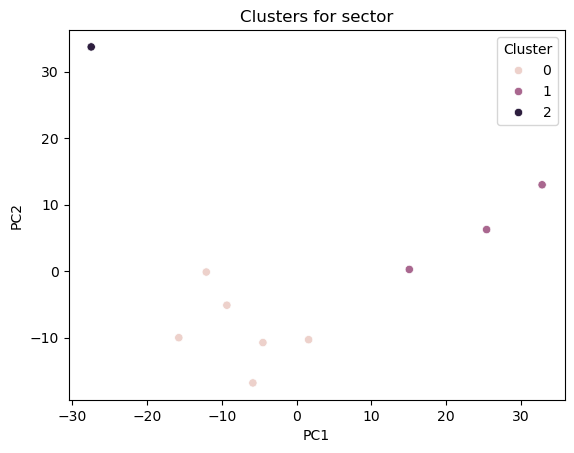

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

Clusters for sector_twins:
     ETF  Cluster        PC1        PC2
0    XLF        6 -14.383644 -10.132901
1    VFH        6 -12.967798  -9.646297
2    XLK        4  -5.118501 -16.730086
3    VGT        4  -6.268763 -17.852236
4    XLY        8  -3.544622 -10.683223
5    VCR        8  -4.758012 -10.904734
6    XLP        0  15.629020   1.491682
7    VDC        0  14.763838   1.407236
8    XLV        5   2.662511  -9.993991
9    VHT        5   0.963318 -11.254032
10   XLE        2 -28.077029  31.795562
11   VDE        2 -31.240140  33.720519
12   XLI        1  -8.519502  -5.307528
13   VIS        1  -9.531829  -5.550242
14   XLB        1 -11.600932  -0.691984
15   VAW        1 -12.948226  -1.047594
16   XLU        3  32.760160  14.716975
17   VPU        3  31.267850  14.276717
18  XLRE        7  25.304548   6.917361
19   VNQ        7  24.233790   6.587181
20   VOX        9   1.373961  -1.118385


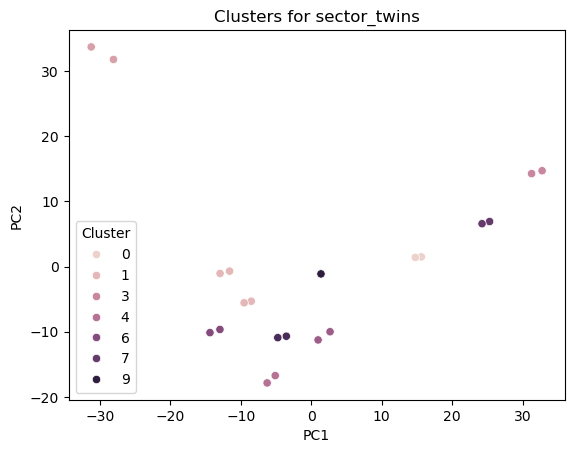

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clusters for dividend:
    ETF  Cluster        PC1        PC2
0   VYM        2 -12.727306 -17.044051
1   HDV        0 -11.694497  46.475409
2  SCHD        2 -27.186955 -23.421293
3   DVY        1  51.608758  -6.010065


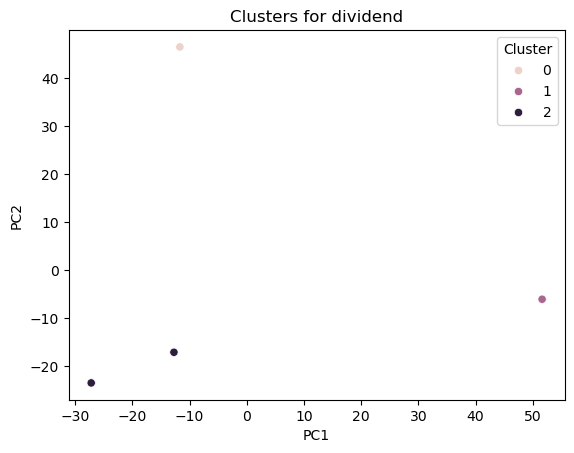

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

Clusters for bond:
    ETF  Cluster        PC1        PC2
0   SHY        2 -53.652900 -10.386743
1  VGSH        2 -54.373496 -11.480488
2   IEF        0 -10.495711  24.445984
3   TLH        0   9.820068  19.002455
4   TLT        1  59.481142  -4.804381
5  SPTL        1  49.220897 -16.776827


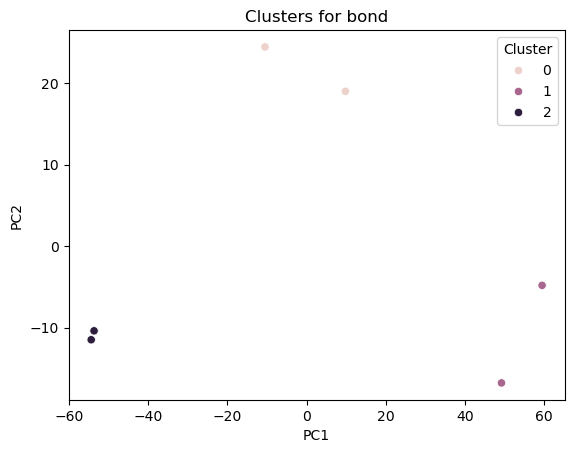

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

Clusters for international:
    ETF  Cluster        PC1        PC2
0   EFA        2 -16.772769 -11.733720
1   VEA        2 -16.185620 -10.375801
2  IEMG        0   6.747059  15.611027
3   EEM        0   8.719650  17.431126
4   EWJ        2 -21.687136 -10.112099
5   EWU        2 -16.198521 -13.970174
6   EWG        2 -18.016024 -16.237963
7   FXI        3   0.909253  48.764946
8   EWZ        1  72.484107 -19.377343


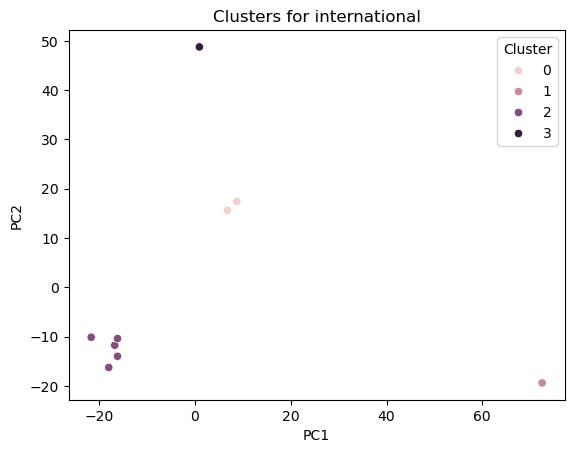

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

Clusters for broad_index:
    ETF  Cluster        PC1        PC2
0   SPY        0 -14.795609 -11.281544
1   VOO        0 -14.732180 -11.075877
2   IVV        0 -15.237418 -11.561126
3   DIA        0 -30.725660 -28.695538
4   IWM        2  75.182633 -13.758676
5   QQQ        1 -11.236434  54.885741
6   RSP        0   3.471589 -19.499541
7  QQEW        1   8.073079  40.986561


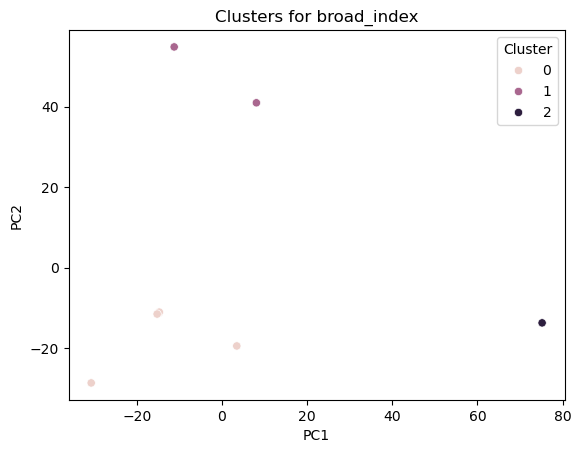

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

Clusters for thematic:
    ETF  Cluster        PC1        PC2
0  ARKK        0 -24.065668  14.634318
1  ARKW        0 -19.286199   9.974137
2  ROBO        1  -1.949361 -11.938360
3  BOTZ        1  -2.455041 -15.778659
4   TAN        2  25.889788  21.622079
5  ICLN        2  17.925232  -0.306514
6   LIT        1   3.941249 -18.207001


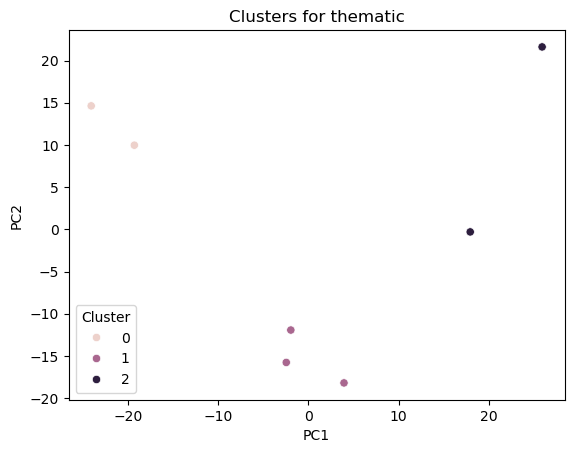

In [67]:
# k-means / PCA

for category, etfs in etf_categories.items():
    desired_etfs = [etf for etf in etfs]

    category_prices = prices[desired_etfs]

    returns = category_prices.pct_change().dropna()

    scaler = StandardScaler()
    returns_scaled = scaler.fit_transform(returns.T)

    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(returns_scaled)

    max_clusters = min(len(etfs) - 1, 10)

    best_k = 2
    best_score = -1

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(pca_components)
        score = silhouette_score(pca_components, labels)
        if score > best_score:
            best_score = score
            best_k = k

    kmeans = KMeans(n_clusters = best_k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)

    cluster_df = pd.DataFrame({
        'ETF': returns.columns,
        'Cluster': labels,
        'PC1': pca_components[:, 0],
        'PC2': pca_components[:, 1]
    })

    print(f"Clusters for {category}:")
    print(cluster_df)

    sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='Cluster')
    plt.title(f"Clusters for {category}")
    plt.show()

    cluster_df = cluster_df.sort_values(by='Cluster')